# Density at 150 pc - pericenter relation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py

from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import run_best_fit, log_model
from density_pericenter_fit_utils import run_best_fit_for_sim
from density_pericenter_fit_utils import run_best_fit_for_sim_with_mcmc
from satellite_properties_plot_utils import plot_median_relation


#################
# Plot parameters
params = {
    "font.size": 11,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (12, 7),
    "figure.subplot.left": 0.06,
    "figure.subplot.right": 0.98,
    "figure.subplot.bottom": 0.17,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.02,
    "figure.subplot.hspace": 0.02,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)

cmap = matplotlib.cm.RdYlBu
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.4, vmax=11)



## First we deal with observational data

In [2]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

Vmax = Kaplinghat_data[:,2]
le_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,3]
he_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,4]
NFW_Vmax = 10**Vmax[::2] # Only NFW fit data; [km/s] units
le_NFW_Vmax = NFW_Vmax - 10**le_Vmax[::2] # Only NFW fit data; [km/s] units
he_NFW_Vmax = 10**he_Vmax[::2] - NFW_Vmax # Only NFW fit data; [km/s] units

Rmax = Kaplinghat_data[:,5]
le_Rmax = Kaplinghat_data[:,6] + Kaplinghat_data[:,5]
he_Rmax = Kaplinghat_data[:,7] + Kaplinghat_data[:,5]
NFW_Rmax = 10**Rmax[::2] # Only NFW fit data; [kpc] units
le_NFW_Rmax = NFW_Rmax - 10**le_Rmax[::2]  # Only NFW fit data; [kpc] units
he_NFW_Rmax = 10**he_Rmax[::2] - NFW_Rmax  # Only NFW fit data; [kpc] units
he_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2
le_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2

num_satellites = len(NFW_Rmax)
M200_K19 = np.zeros((3,num_satellites))
R200_K19 = np.zeros((3,num_satellites))

rho_s = np.zeros(num_satellites)
r_s = np.zeros(num_satellites)
r_range = np.arange(-4, 4, 0.01) # Some radial range
r_range = 10**r_range # to kpc

for i in range(num_satellites):
    rho_s[i] = calculate_rho_s(NFW_Vmax[i], NFW_Rmax[i])
    r_s[i] = calculate_r_s(NFW_Rmax[i])
    rho = NFW_profile(r_range, rho_s[i], r_s[i])
    mass_within_r = mass(rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[0, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[0, i] = calculate_M200(R200_K19[0, i])

    ## Dealing with error propagration..
    low_error_rho = rho - calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], le_NFW_Vmax[i], le_NFW_Rmax[i])
    mass_within_r = mass(low_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[1, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[1, i] = M200_K19[0, i] - calculate_M200(R200_K19[1, i])

    high_error_rho = rho + calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], he_NFW_Vmax[i], he_NFW_Rmax[i])
    mass_within_r = mass(high_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[2, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[2, i] = calculate_M200(R200_K19[2, i]) - M200_K19[0, i]

In [3]:
# We remove CVnI
num_satellites -= 1
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

In [4]:
samples_isolated = run_best_fit(r_p_Isolated, rho_150pc_K19)
samples_LMC = run_best_fit(r_p_LMC, rho_150pc_K19)

def get_q_m_from_samples(samples):
    q = np.median(samples[:, 0])
    m = np.median(samples[:, 1])
    qerrl = np.percentile(samples[:, 0], 16)
    qerrh = np.percentile(samples[:, 0], 84)
    merrl = np.percentile(samples[:, 1], 16)
    merrh = np.percentile(samples[:, 1], 84)
    return q, m, qerrl, qerrh, merrl, merrh

q_isolated, m_isolated, qerrl_isolated, qerrh_isolated, merrl_isolated, merrh_isolated = get_q_m_from_samples(samples_isolated)
q_LMC, m_LMC, qerrl_LMC, qerrh_LMC, merrl_LMC, merrh_LMC = get_q_m_from_samples(samples_LMC)

2.6718528330180216 -0.8753658074883338


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.11it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.14167612 25.55853565]


Multiprocessing took 0.0 minutes
Mean autocorrelation time: 25.350 steps
2.0560949406100315 -0.4870925580939238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.16it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.70842891 27.55232182]


Multiprocessing took 0.0 minutes
Mean autocorrelation time: 27.630 steps


In [5]:
def plot_obs(axs):

    # Data points
    axs.errorbar(r_p_Isolated[0,:], rho_150pc_K19[0,:], xerr=r_p_Isolated[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='o', markersize=7, markeredgecolor="white", ls='none', lw=0.5, c='tab:blue',label='Isolated MW')
    axs.errorbar(r_p_LMC[0,:], rho_150pc_K19[0,:], xerr=r_p_LMC[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='v', markersize=7, markeredgecolor="white", ls='none', lw=0.5, c='crimson',label='MW + LMC')

    # Fit
    # xrange = np.arange(1, 3.2, 0.2)
    # num_range = len(xrange)
    # for samples, color in zip([samples_isolated, samples_LMC], ["tab:blue", "crimson"]):
    #     q = np.median(samples[:, 0])
    #     m = np.median(samples[:, 1])
    #     yrange = np.ones((2,num_range))
    #     for i in range(num_range):
    #         yrange[0, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 16)
    #         yrange[1, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 84)
    #     axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color=color, alpha=0.1)
    #     axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '--', lw=1, color=color)

    # Include the fit from Cardona+ 2023
    xrange = np.arange(1, 3.2, 0.2)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, 2.3, -0.6), '--', lw=1.5, color="tab:blue")
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, 1.4, -0.1), '--', lw=1.5, color="crimson")
    
    axs.legend(loc=[0.01, 0.01], labelspacing=0.1, handlelength=0.7, handletextpad=0.2, frameon=False, fontsize=15, ncol=1, numpoints=1)
    axs.set_yscale('log')
    axs.set_xscale('log')
    axs.set_xlabel("$r_{p}$ [kpc]")
    axs.axis([10, 500, 2e6, 2e9])


## We introduce the analysis with the simulations

In [6]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
#    "SigmaConstant10": "SigmaConstant10", # I will not include this sim. since its cross section is already ruled out by galaxy clusters
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.79it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 17.022 steps


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.96it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 16.788 steps


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.86it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 16.552 steps


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.62it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 16.666 steps


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.96it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 16.613 steps


<Figure size 960x560 with 0 Axes>

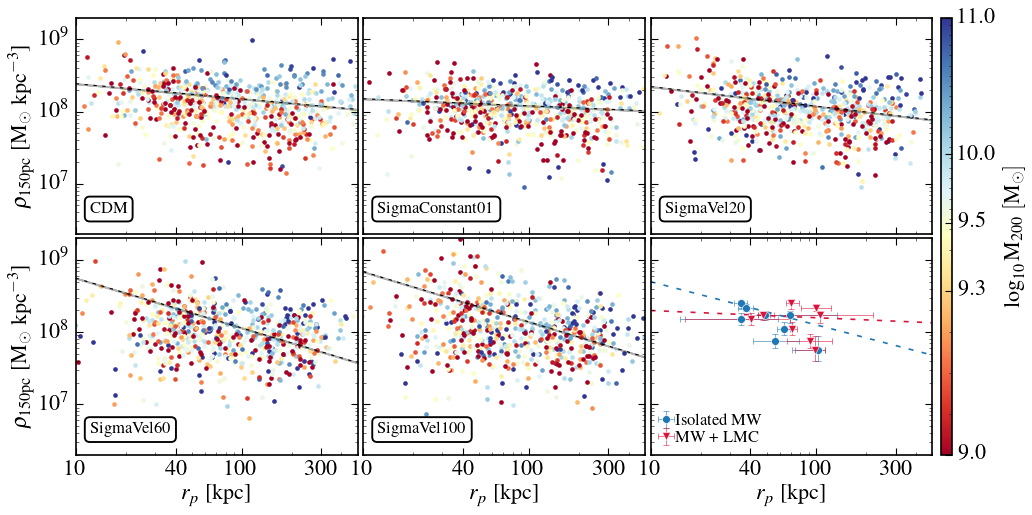

In [7]:
plt.figure()
fig, all_axs = plt.subplots(2, 3, sharex=True)
all_axs = all_axs.flatten()

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i]

    x = []
    y = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get('subhalo_of') is not None:    
            data_subhalo = file[f'{idx}']
            nfw_fit = data_subhalo['halo_data']['nfw_fit']
            r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
            rho_s = 10**log10_rho_s
            sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
            rho = NFW_profile(r_range, rho_s, r_s)
            mass_within_r = mass(rho, r_range)
            rho_within_r = rho_mean(mass_within_r, r_range)
            R200 = calculate_R200(rho_within_r, r_range)
            M200 = calculate_M200(R200)
            r_p = data_subhalo['tree_data']['pericenter'][1]
            rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
            
            im = axs.scatter(r_p, rho_150, c=np.log10(M200), cmap=cmap, marker='.', 
                             lw=0, norm=normalize, alpha=1, s=70)

            # Let's append for this sim:
            x = np.append(x, r_p)
            y = np.append(y, rho_150)

    # Some values for rho_150 do not look good, let's clean..
    clean = np.where((y>=1e6) & (y<=1e10))[0]
    y = y[clean]
    x = x[clean]

    samples_Simulation = run_best_fit_for_sim_with_mcmc(x, y)

    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    q = np.median(samples_Simulation[:, 0])
    m = np.median(samples_Simulation[:, 1])
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], samples_Simulation[:, 0], samples_Simulation[:, 1]), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], samples_Simulation[:, 0], samples_Simulation[:, 1]), 84)

    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.3)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '--', lw=1, color='black')

    props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
    axs.text(0.05, 0.15, id_name, transform=axs.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)
    
    axs.axis([10, 500, 2e6, 2e9])
    axs.set_xscale('log')
    axs.set_yscale('log')

    xticks = np.array([10, 40, 100, 300])
    labels = ["10","40","100","300"]
    axs.set_xticks(xticks, labels)
    
    if i >= 3:
        axs.set_xlabel(r"$r_{p}$ [kpc]")
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i == 0) or (i==3):
        axs.set_ylabel(r"$\rho_{\mathrm{150pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    else:
        axs.get_yaxis().set_ticklabels([])


    ####
    file.close()

####
axs = all_axs[5]
plot_obs(axs)
xticks = np.array([10, 40, 100, 300])
labels = ["10","40","100","300"]
axs.set_xticks(xticks, labels)
axs.get_yaxis().set_ticklabels([])

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{200}}$ $\mathrm{[M_\odot]}$',
                    aspect=40, fraction=0.02, pad=0.01)
cbar.ax.set_yticks([9, 9.3, 9.5, 10, 11]) 


plt.savefig('Density_pericenter.png',dpi=300)
plt.show()

<Figure size 960x560 with 0 Axes>

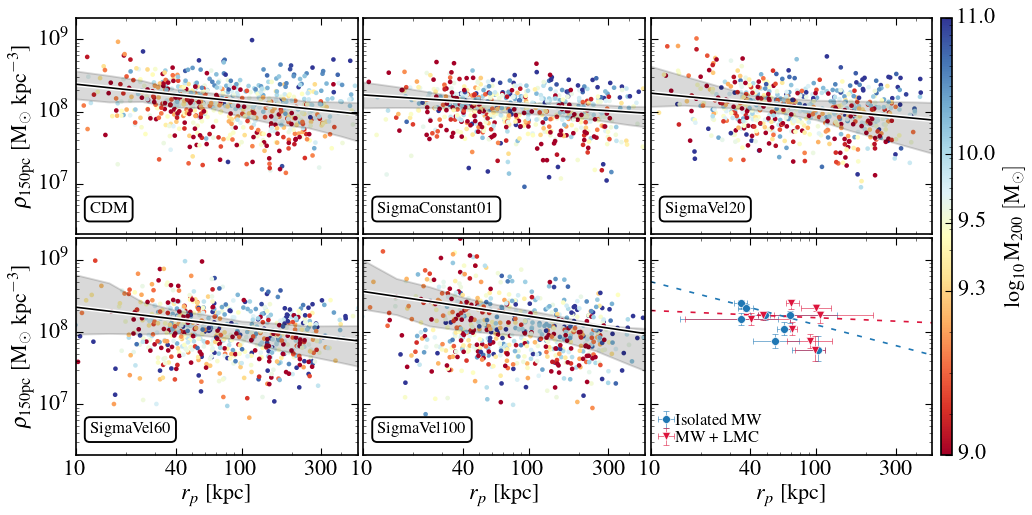

In [10]:
plt.figure()
fig, all_axs = plt.subplots(2, 3, sharex=True)
all_axs = all_axs.flatten()

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i]
        
    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                rho = NFW_profile(r_range, rho_s, r_s)
                mass_within_r = mass(rho, r_range)
                rho_within_r = rho_mean(mass_within_r, r_range)
                R200 = calculate_R200(rho_within_r, r_range)
                _M200 = calculate_M200(R200)
                M200 = np.append(M200, _M200)

            im = axs.scatter(rp, rho150, c=np.log10(M200), cmap=cmap, marker='.', 
                             lw=0, norm=normalize, alpha=1, s=70)

            # Fit
            if counter <= 8:
                _q, _m = run_best_fit_for_sim(rp, rho150)
                q = np.append(q, _q)
                m = np.append(m, _m)

            counter += 0
    

    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 84)

    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.15)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=4, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=1.5, color='black')

    props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
    axs.text(0.05, 0.15, id_name, transform=axs.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)
        
    axs.axis([10, 500, 2e6, 2e9])
    axs.set_xscale('log')
    axs.set_yscale('log')

    xticks = np.array([10, 40, 100, 300])
    labels = ["10","40", "100","300"]
    axs.set_xticks(xticks, labels)
    
    if i >= 3:
        axs.set_xlabel(r"$r_{p}$ [kpc]")
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i == 0) or (i==3):
        axs.set_ylabel(r"$\rho_{\mathrm{150pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()

####
axs = all_axs[5]
plot_obs(axs)
xticks = np.array([10, 40, 100, 300])
labels = ["10","40","100","300"]
plt.xticks(xticks, labels)
axs.get_yaxis().set_ticklabels([])


####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{200}}$ $\mathrm{[M_\odot]}$',
                    aspect=40, fraction=0.02, pad=0.01)
cbar.ax.set_yticks([9, 9.3, 9.5, 10, 11]) 


####
plt.savefig('Density_pericenter_v2.png',dpi=300)
plt.show()


In [ ]:
cmap = matplotlib.cm.RdYlBu
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.4, vmax=10.5)

plt.figure()
fig, all_axs = plt.subplots(2, 3, sharex=True)
all_axs = all_axs.flatten()

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i]
        
    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])

                z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]                
                M200 = np.append(M200, mass_peak)
    
                # sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                # rho = NFW_profile(r_range, rho_s, r_s)
                # mass_within_r = mass(rho, r_range)
                # rho_within_r = rho_mean(mass_within_r, r_range)
                # R200 = calculate_R200(rho_within_r, r_range)
                # _M200 = calculate_M200(R200)
                # M200 = np.append(M200, _M200)

            im = axs.scatter(rp, rho150, c=np.log10(M200), cmap=cmap, marker='.', 
                             lw=0, norm=normalize, alpha=1, s=70)

            # Fit
            select = np.arange(0,8)            
            _q, _m = run_best_fit_for_sim(rp[select], rho150[select])
            q = np.append(q, _q)
            m = np.append(m, _m)
    

    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 84)

    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.15)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=4, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=1.5, color='black')

    props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
    axs.text(0.05, 0.15, id_name, transform=axs.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)
        
    axs.axis([10, 500, 2e6, 2e9])
    axs.set_xscale('log')
    axs.set_yscale('log')

    xticks = np.array([10, 40, 100, 300])
    labels = ["10","40", "100","300"]
    axs.set_xticks(xticks, labels)
    
    if i >= 3:
        axs.set_xlabel(r"$r_{p}$ [kpc]")
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i == 0) or (i==3):
        axs.set_ylabel(r"$\rho_{\mathrm{150pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()

####
axs = all_axs[5]
plot_obs(axs)
xticks = np.array([10, 40, 100, 300])
labels = ["10","40","100","300"]
plt.xticks(xticks, labels)
axs.get_yaxis().set_ticklabels([])


####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{\mathrm{peak}}}$ $\mathrm{[M_\odot]}$',
                    aspect=40, fraction=0.02, pad=0.01)
cbar.ax.set_yticks([9, 9.3, 9.5, 10, 10.5]) 


####
plt.savefig('Density_pericenter_Mpeak.png',dpi=300)
plt.show()